In [505]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile

import sys
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [506]:
from analysis import sweep2df

In [446]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [555]:
bundles.neurips2022(usetex=False)

{'text.usetex': False,
 'font.serif': ['Times New Roman'],
 'mathtext.fontset': 'stix',
 'mathtext.rm': 'Times New Roman',
 'mathtext.it': 'Times New Roman:italic',
 'mathtext.bf': 'Times New Roman:bold',
 'font.family': 'serif',
 'figure.figsize': (5.5, 3.399186938124422),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'font.size': 9,
 'axes.labelsize': 9,
 'legend.fontsize': 7,
 'xtick.labelsize': 7,
 'ytick.labelsize': 7,
 'axes.titlesize': 9}

In [593]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "2y77igd1"


In [601]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"moebius_sweep_{SWEEP_ID}.csv"

In [602]:
runs_df = sweep2df(sweep.runs, filename, True)

In [603]:
runs_df

,name,dim,gamma_square,neg_elbo,kl_loss,rec_loss,prior,cima,mcc,min_cima,...,mse_obs_decoded_mean_latents,sigma_0,sigma_1,sigma_2,col_norm_sq_0,col_norm_sq_1,col_norm_sq_2,rhs_0,rhs_1,rhs_2
0,divine-sweep-91,3,10000.0,-4.729356,-4.697728,9.427084,uniform,0.001895,0.964908,0.000579,...,0.263980,0.160965,0.139997,0.162194,0.028586,0.036056,0.031063,0.003498,0.002773,0.003219
1,zesty-sweep-89,3,1000.0,-4.674113,-1.463038,6.137150,uniform,0.003139,0.761142,0.001565,...,0.045212,1.181926,1.183973,1.162742,0.022586,0.019812,0.019738,0.044276,0.050476,0.050664
2,prime-sweep-88,3,1000.0,-4.685496,-1.308515,5.994011,uniform,1.145277,0.519015,0.105605,...,0.477824,1.024691,2.973552,0.989277,0.022789,0.000009,0.027610,0.043882,106.202894,0.036219
3,good-sweep-87,3,1000.0,-4.687576,-1.468272,6.155848,uniform,0.002866,0.765559,0.001779,...,0.166592,1.187941,1.201220,1.101350,0.020249,0.025001,0.020729,0.049385,0.039998,0.048241
4,summer-sweep-86,3,1000.0,-4.689777,-1.457868,6.147645,uniform,0.004330,0.766174,0.002475,...,0.037524,1.180895,1.151842,1.138771,0.017201,0.021222,0.020243,0.058135,0.047121,0.049401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,hearty-sweep-16,3,10.0,-0.628291,-0.029677,0.657968,uniform,1.681410,0.149829,0.419867,...,0.002663,3.051715,3.196243,3.118419,0.000015,0.000017,0.000044,6813.537006,5913.999350,2263.865816
81,worldly-sweep-14,3,10.0,-0.629037,-0.028636,0.657673,uniform,2.732165,0.152009,0.672617,...,0.003187,3.133762,3.053871,3.105312,0.000034,0.000049,0.000043,2946.676136,2028.687045,2347.593478
82,electric-sweep-13,3,10.0,-0.629196,-0.028810,0.658006,uniform,0.139535,0.151928,0.139535,...,0.002722,2.980591,3.030186,2.984174,0.000033,0.000041,0.000009,3024.593273,2462.646376,11314.802235
83,amber-sweep-5,3,10.0,-0.630610,-0.026974,0.657584,uniform,2.011273,0.147999,0.895605,...,0.003388,3.030219,3.165489,3.011441,0.000026,0.000054,0.000005,3847.065156,1842.198024,19432.445254


$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [619]:
runs_df[[ "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

cima4min_neg_elbo                                          \
                         count      mean       std       min       25%   
gamma_square                                                             
10.0                      20.0  1.335482  0.564094  0.611589  0.792626   
100.0                     20.0  1.236132  0.559228  0.450587  0.768593   
1000.0                    19.0  0.068911  0.139163  0.002055  0.002738   
10000.0                    5.0  0.002187  0.000800  0.001298  0.001968   
100000.0                   4.0  0.002753  0.001059  0.001692  0.001932   
1000000.0                 17.0  0.001823  0.001684  0.000057  0.001126   

                                            
                   50%       75%       max  
gamma_square                                
10.0          1.350295  1.737893  2.397702  
100.0         1.049250  1.718161  2.334175  
1000.0        0.004156  0.007729  0.444581  
10000.0       0.002072  0.002104  0.003491  
100000.0      0.002747  0.003568  0.003828  
1000000.0     0.001760  0.001897  0.007712

In [620]:
runs_df[[ "mcc4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

mcc4min_neg_elbo                                          \
                        count      mean       std       min       25%   
gamma_square                                                            
10.0                     20.0  0.152054  0.002594  0.145711  0.150620   
100.0                    20.0  0.150781  0.003009  0.144056  0.149297   
1000.0                   19.0  0.711884  0.095085  0.529063  0.738003   
10000.0                   5.0  0.957869  0.003668  0.953923  0.955529   
100000.0                  4.0  0.965469  0.005658  0.960781  0.961006   
1000000.0                17.0  0.869612  0.081924  0.681927  0.829863   

                                            
                   50%       75%       max  
gamma_square                                
10.0          0.151827  0.153587  0.156768  
100.0         0.150826  0.152549  0.156737  
1000.0        0.758195  0.764575  0.773091  
10000.0       0.956393  0.961280  0.962221  
100000.0      0.964238  0.968701  0.972617  
1000000.0     0.891885  0.928086  0.966841

In [621]:
runs_df[[ "min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

min_neg_elbo                                                    \
                    count      mean       std       min       25%       50%   
gamma_square                                                                  
10.0                 20.0 -0.631330  0.001146 -0.633572 -0.632227 -0.631218   
100.0                20.0 -3.733695  0.001176 -3.736262 -3.734592 -3.733493   
1000.0               19.0 -4.696911  0.014440 -4.711015 -4.707474 -4.705772   
10000.0               5.0 -4.650475  0.140143 -4.813470 -4.767874 -4.631502   
100000.0              4.0 -3.499604  0.209781 -3.751734 -3.632163 -3.466880   
1000000.0            17.0 -1.078317  0.445259 -1.910325 -1.277730 -1.067890   

                                  
                   75%       max  
gamma_square                      
10.0         -0.630326 -0.629624  
100.0        -3.732953 -3.731812  
1000.0       -4.687442 -4.660370  
10000.0      -4.562657 -4.476871  
100000.0     -3.334322 -3.312922  
1000000.0    -0.758272 -0.202977

In [622]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

In [623]:
df_mse_sources_mean_decoded_sources = pd.DataFrame(runs_df[[col for col in runs_df.columns if col == "mse_sources_mean_decoded_sources"]].stack().droplevel(1), columns=["mse_sources_mean_decoded_sources"])
df_mse_obs_decoded_mean_latents = pd.DataFrame(runs_df[[col for col in runs_df.columns if col == "mse_obs_decoded_mean_latents"]].stack().droplevel(1), columns=["mse_obs_decoded_mean_latents"])
df_mse_gamma_sq = df_mse_sources_mean_decoded_sources.merge( df_mse_obs_decoded_mean_latents, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

In [624]:
def create_violinplot(groups, xlabel, ylabel, xticklabels, filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    vp= plt.violinplot(groups, showmedians=True)
    for el in vp['bodies']:
        el.set_facecolor('#1A85FF')
        el.set_edgecolor('black')
        el.set_linewidth(1.5)
        el.set_alpha(.9)
    for pn in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        vp_ = vp[pn]
        vp_.set_edgecolor('black')
        vp_.set_linewidth(1)
    ax.set_xticklabels(xticklabels)
    # ax.set_xticks(xticks)
    # plt.locator_params(axis='y', nbins=5)
    # plt.yticks(fontsize=24)
    # plt.ylim([0, 0.5])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if filename is not None:
        plt.savefig(f"{filename}.svg")

In [625]:
from tueplots  import figsizes

In [569]:
figsizes.neurips2022(ncols=3)['figure.figsize']

(5.5, 1.1330623127081405)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/527131785.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(im)


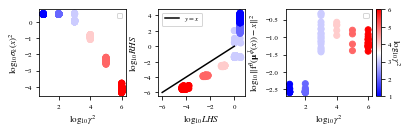

In [626]:
fig = plt.figure(figsize=figsizes.neurips2022(nrows=1,ncols=2)['figure.figsize'])

ax = fig.add_subplot(131)
im = ax.scatter(np.log10(df_rhs_lhs_gamma_sq.gamma_square),np.log10(df_rhs_lhs_gamma_sq.lhs),  c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap="bwr")
# ax.plot(np.linspace(.85, 6), np.linspace(0, -5), c="black", label='$y=x^{-2}$')
ax.set_ylabel("$\log_{10}\sigma_k(x)^2$")
ax.set_xlabel("$\log_{10}\gamma^2$")
plt.legend()

ax = fig.add_subplot(132)
ax.scatter(np.log10(df_rhs_lhs_gamma_sq.lhs), np.log10(df_rhs_lhs_gamma_sq.rhs), c=np.log10(df_rhs_lhs_gamma_sq.gamma_square), cmap='bwr')
ax.plot(np.linspace(-6, 0.), np.linspace(-6, 0.), c="black", label='$y=x$')
ax.set_ylabel("$\log_{10} RHS$")
ax.set_xlabel("$\log_{10} LHS$")
plt.legend()


ax = fig.add_subplot(133)
ax.scatter(np.log10(df_mse_gamma_sq.gamma_square),np.log10(df_mse_gamma_sq.mse_obs_decoded_mean_latents),  c=np.log10(df_mse_gamma_sq.gamma_square), cmap="bwr")
# ax.plot(np.linspace(.85, 6), -4*(np.linspace(.85, 6)), c="black", label='$y=x^{-4}$')
ax.set_ylabel(r"$\log_{10}\Vert {\mathbf{\rm f}^\theta}(\mathbf{\mu}^{\hat{\phi}}(x)) - x \Vert^2$")
ax.set_xlabel("$\log_{10}\gamma^2$")
plt.legend()


cbar = fig.colorbar(im)
# cbar.ax.set_yticklabels(['0','1','2','>3'])
cbar.set_label('$\log_{10}\gamma^2$', rotation=270)
cbar.ax.get_yaxis().labelpad = 10
plt.savefig("self_cons.svg")

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


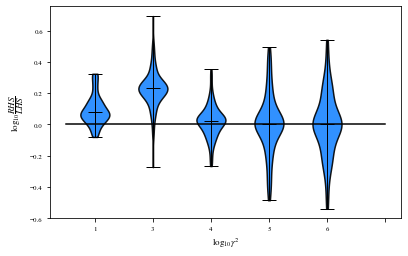

In [503]:
groups = [np.log10((g.rhs/g.lhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
create_violinplot(groups, '$\log_{10}\gamma^2$', '$\log_{10}\dfrac{RHS}{LHS}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="opt_sigma_gamma")
plt.plot(np.linspace(0.5, 6), 0*np.linspace(0.5, 6), c="black")

In [608]:
elbo_filter = runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()['neg_elbo']['max']
groups = [g for _, g in runs_df[[ "neg_elbo", "mcc4min_neg_elbo", "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square")]
gg_mcc = [g[g.neg_elbo <= threshold].mcc4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_cima = [g[g.neg_elbo <= threshold].cima4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_gamma = [g[g.neg_elbo <= threshold].gamma_square  for g, threshold in zip(groups, elbo_filter)]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


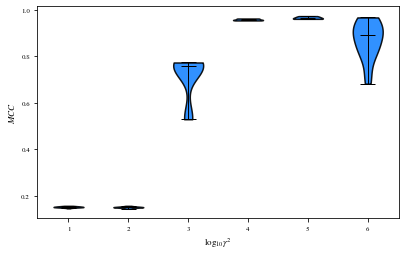

In [609]:
create_violinplot(gg_mcc, '$\log_{10}\gamma^2$', '$MCC$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="mcc_vs_gamma")

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_10088/2860315922.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


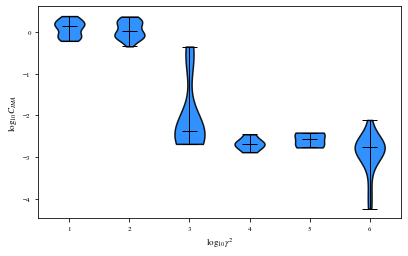

In [610]:
create_violinplot([np.log10(g) for g in gg_cima], '$\log_{10}\gamma^2$', '$\log_{10}C_{IMA}$', [0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()), filename="cima_vs_gamma")

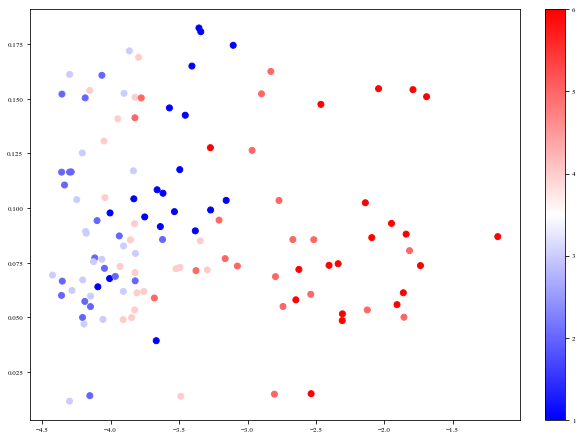

In [529]:
plt.figure(figsize=(8,6))
plt.scatter([np.log10(item) for sublist in gg_cima for item in sublist],[-np.log10(item) for sublist in gg_mcc for item in sublist], c=[np.log10(item) for sublist in gg_gamma for item in sublist], cmap="bwr")
plt.colorbar()

In [494]:
larger_gamma_df = runs_df[runs_df['gamma_square']>100]

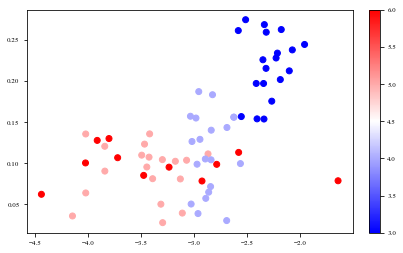

In [495]:
plt.scatter(np.log10(larger_gamma_df['cima4min_neg_elbo']), -np.log10(larger_gamma_df['mcc4min_neg_elbo']), c=np.log10(larger_gamma_df['gamma_square']), cmap='bwr')
plt.colorbar()

In [372]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)

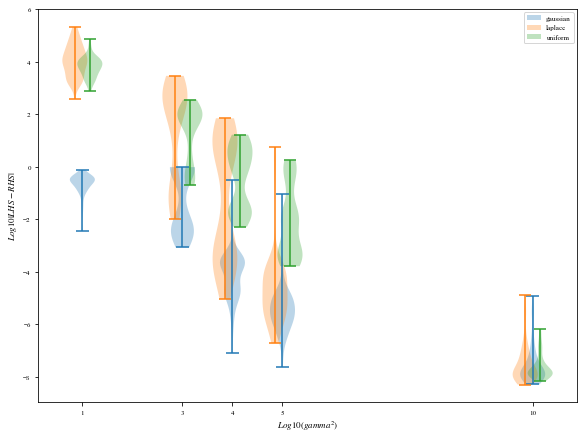

In [49]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)